In [1]:
import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [2]:
###############################################################################
# OPTIONAL: Change the temp directory to avoid writing large temp files to C: 
###############################################################################
# On Windows, do this BEFORE you start any large process or import DataGenerators.
tempfile.tempdir = r"D:\Temp"  # Replace with a path on a drive with ample space

# Alternatively (outside Python), you could set environment vars:
#    set TEMP=D:\Temp
#    set TMP=D:\Temp
# Then start Jupyter or your script from the same console.




###############################################################################
# Paths to datasets (assuming your dataset is structured properly)
###############################################################################
TRAIN_PATH = r"D:\Yash\Documents\Projects\_My Projects_\ML\5 Fake Currency\Dataset\Train"
TEST_PATH  = r"D:\Yash\Documents\Projects\_My Projects_\ML\5 Fake Currency\Dataset\Test"



In [3]:
###############################################################################
# Image size for the model (optimized)
###############################################################################
# Note: MobileNet was originally trained on 224x224. 
# If aspect ratio is important, you can do 224x448 or something similar.
IMAGE_SIZE = (224, 448)


In [4]:
###############################################################################
# Data generator for training and validation
###############################################################################
# 1) Using 'preprocess_input' can help match the original MobileNet training scheme.
# 2) Reducing shear/zoom/etc. can also help if your dataset doesn't need heavy augmentation.
###############################################################################
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # or rescale=1./255 if you prefer
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Reserve 20% for validation
)

train_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=8,              # smaller batch size to reduce memory usage
    class_mode="binary",
    subset="training",
)

valid_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=8,
    class_mode="binary",
    subset="validation",
)


Found 33 images belonging to 2 classes.
Found 7 images belonging to 2 classes.


In [5]:
###############################################################################
# Load MobileNet base model (lighter than many other architectures)
###############################################################################
base_model = MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3)
)


D:\Temp\ipykernel_14260\695250551.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(


In [6]:
###############################################################################
# Add custom layers for binary classification
###############################################################################
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)  # Sigmoid for binary classification

model = Model(inputs=base_model.input, outputs=predictions)



In [7]:
###############################################################################
# Freeze the base model layers initially
###############################################################################
for layer in base_model.layers:
    layer.trainable = False


In [8]:
###############################################################################
# Compile the model (use a relatively low learning rate)
###############################################################################
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [9]:
###############################################################################
# Train the model
###############################################################################
history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=5,                       # Start with fewer epochs to test stability
    steps_per_epoch=len(train_set),
    validation_steps=len(valid_set),
    verbose=1
)


d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6276 - loss: 0.6976

d:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 499ms/step - accuracy: 0.6002 - loss: 0.7334 - val_accuracy: 0.5714 - val_loss: 0.6914
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.6206 - loss: 0.6861 - val_accuracy: 0.4286 - val_loss: 0.6814
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.7511 - loss: 0.5933 - val_accuracy: 0.5714 - val_loss: 0.6439
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.8114 - loss: 0.5639 - val_accuracy: 0.4286 - val_loss: 0.7326
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.7936 - loss: 0.5172 - val_accuracy: 0.7143 - val_loss: 0.5559


In [10]:
###############################################################################
# OPTIONAL: Fine-tuning 
###############################################################################
# After the above training, you can unfreeze some top layers in base_model 
# and continue training at a lower learning rate.
# For large data / memory constraints, do so carefully.
'''
for layer in base_model.layers[-20:]:  # unfreeze last 20 layers
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_fine_tune = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=5,
    steps_per_epoch=len(train_set),
    validation_steps=len(valid_set),
    verbose=1
)
'''


'\nfor layer in base_model.layers[-20:]:  # unfreeze last 20 layers\n    layer.trainable = True\n\nmodel.compile(\n    optimizer=Adam(learning_rate=1e-5),\n    loss="binary_crossentropy",\n    metrics=["accuracy"]\n)\n\nhistory_fine_tune = model.fit(\n    train_set,\n    validation_data=valid_set,\n    epochs=5,\n    steps_per_epoch=len(train_set),\n    validation_steps=len(valid_set),\n    verbose=1\n)\n'

In [11]:
###############################################################################
# Save the model
###############################################################################
model.save("fake_currency_detector_optimized.h5")


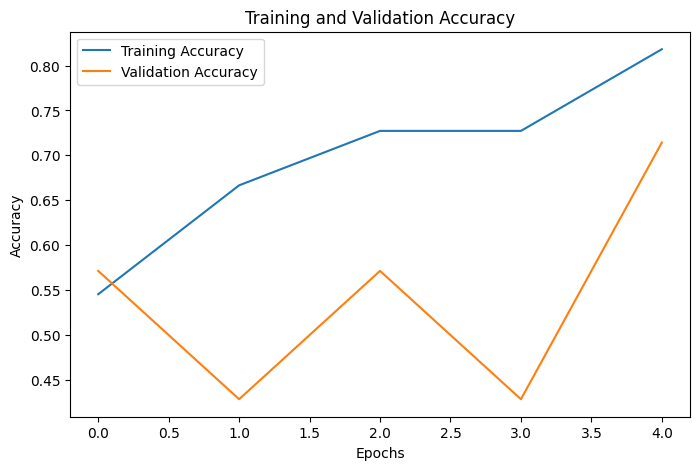

In [12]:
###############################################################################
# Plot training and validation accuracy
###############################################################################
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [13]:
###############################################################################
# Function to predict if a note is real or fake
###############################################################################
def predict_note(model_path, image_path):
    model = load_model(model_path)
    
    # IMPORTANT: Use the same preprocessing as training
    img = load_img(image_path, target_size=IMAGE_SIZE)
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)  # match training preprocessing
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    prediction = model.predict(img_array)[0][0]
    result = "Real" if prediction >= 0.5 else "Fake"
    print(f"Prediction: {result} (Confidence: {prediction:.2f})")

    # Visualize the input image
    plt.imshow(load_img(image_path))  # show original size in matplotlib
    plt.axis("off")
    plt.title(f"Prediction: {result}")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
Prediction: Real (Confidence: 0.63)


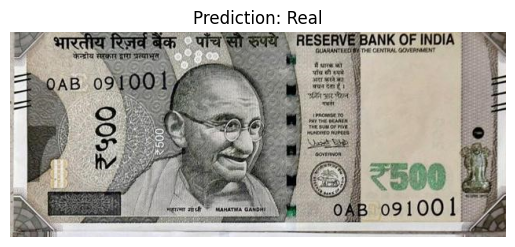

In [14]:
###############################################################################
# Example prediction (optional)
###############################################################################
example_image_path = r"D:\Yash\Documents\Projects\_My Projects_\ML\5 Fake Currency\Dataset\Test\Real\82.jpg"
predict_note("fake_currency_detector_optimized.h5", example_image_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Prediction: Real (Confidence: 0.58)


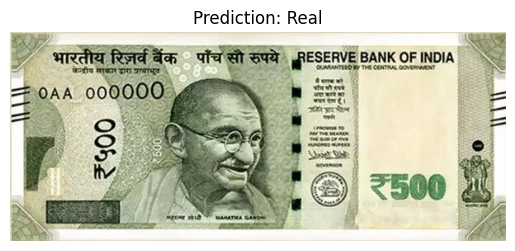

In [15]:
###############################################################################
# Example prediction (optional)
###############################################################################
example_image_path = r"D:\Yash\Documents\Projects\_My Projects_\ML\5 Fake Currency\Dataset\Train\Fake\9f.jpg"
predict_note("fake_currency_detector_optimized.h5", example_image_path)
